In [1]:
import requests
from gql import gql, Client, RequestsHTTPTransport
from IPython.display import display, Markdown
import asyncio

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)


client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

In [2]:
# paste the designed and tested (graphqli) query 
query_string = """
{
  person(id: "https://orcid.org/0000-0002-2906-2577") {
    id
    name
    datasets {
      nodes {
        id
        downloadCount
        viewCount
        citations {
          totalCount
        }
      }
    }
    publications {
      totalCount
      nodes {
        id
        relatedIdentifiers {
          relatedIdentifier
        }
      }
    }
  }
}

"""

query = gql(query_string)
data = client.execute(query)
display(Markdown((data['person']['name'])))


Nicholas Deutscher

In [3]:
# sort the payload dict for total citation counts
ordered = sorted(data['person']['datasets']['nodes'], key=lambda i: i["citations"]["totalCount"], reverse=True)
ordered[:2]


[{'id': 'https://doi.org/10.14291/tccon.ggg2014.darwin01.r0/1149290',
  'downloadCount': 6,
  'viewCount': 75,
  'citations': {'totalCount': 24}},
 {'id': 'https://doi.org/10.14291/tccon.ggg2014.wollongong01.r0/1149291',
  'downloadCount': 7,
  'viewCount': 65,
  'citations': {'totalCount': 20}}]

In [4]:
# reformat the dict for data analysis 

agg=[]

for dataset in ordered:
    agg.append(
        {'id':dataset['id'],
          'downloadCount': dataset['downloadCount'],
          'viewCount': dataset['viewCount'],
          'citationCount': dataset['citations']['totalCount']
        }
    )
  
    #print(node)
#agg


In [5]:
agg.__class__

list

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd

In [33]:
datasets_data = pd.DataFrame(agg)

In [8]:
datasets_data

,id,downloadCount,viewCount,citationCount
0,https://doi.org/10.14291/tccon.ggg2014.darwin0...,6,75,24
1,https://doi.org/10.14291/tccon.ggg2014.wollong...,7,65,20
2,https://doi.org/10.14291/tccon.ggg2014.orleans...,1,18,19
3,https://doi.org/10.14291/tccon.ggg2014.bremen0...,2,18,15
4,https://doi.org/10.14291/tccon.ggg2014.bialyst...,1,21,11
5,https://doi.org/10.14291/tccon.ggg2014.nyalesu...,1,10,1
6,https://doi.org/10.1594/pangaea.848263,0,0,0
7,https://doi.org/10.1594/pangaea.872007,0,0,0
8,https://doi.org/10.14291/tccon.ggg2014.nyalesu...,1,44,0
9,https://doi.org/10.14291/tccon.ggg2014.bremen0...,2,51,0


In [9]:
display(datasets_data.describe())
display(datasets_data.sum())

,downloadCount,viewCount,citationCount
count,12.000000,12.000000,12.000000
mean,2.583333,32.583333,7.500000
std,2.466441,25.256712,9.577436
min,0.000000,0.000000,0.000000
25%,1.000000,16.000000,0.000000
50%,1.500000,27.500000,0.500000
75%,5.000000,52.000000,16.000000
max,7.000000,75.000000,24.000000


id               https://doi.org/10.14291/tccon.ggg2014.darwin0...
downloadCount                                                   31
viewCount                                                      391
citationCount                                                   90
dtype: object

In [18]:
def h_index(citationarray):
    import numpy as np
    descending_df = pd.DataFrame(citationarray)
    descending_df.columns = ['count']
    descending_df=descending_df.sort_values(by=['count'], ascending=False)
    counter = [*range(len(descending_df['count'].index),0,-1)]
    for dC in [*range(len(descending_df['count'].index),0,-1)]:
        descending_df[dC] = descending_df.apply(lambda x : True
                if x['count'] >= dC else False, axis = 1)

        counter[len(descending_df['count'].index)-dC] = len(descending_df[dC][descending_df[dC] == True].index)
    summary = pd.DataFrame({'count': descending_df['count'],'citation': [*range(len(descending_df['count'].index),0,-1)],'h_index': counter})
    h=summary.loc[summary['citation'] == summary['h_index']]['h_index'].array[0]
    return h
h_index(datasets_data['citationCount'])

5

In [19]:
def i10_index(citationarray):
    series = citationarray.apply(lambda x: True if x > 0 else False)
    cited_papers = len(series[series == True].index)
    i10_column = citationarray.apply(lambda x: True if x >= 10 else False)
    return len(i10_column[i10_column == True].index)

In [20]:
def g_index(citationarray):
    import numpy as np
    import math
    descending_df = pd.DataFrame(citationarray)
    descending_df.columns = ['count']
    descending_df=descending_df.sort_values(by=['count'], ascending=False)
    series = descending_df.apply(lambda x: True if x['count'] > 0 else False , axis=1)
    cited_papers = len(series[series == True].index)

    ranger = [cited_papers,0,-1]
    g_max = math.floor(np.sqrt(descending_df['count'].sum()))

    if g_max <= cited_papers:
        g = g_max
    else:
        g = 0
        k = True
        while k:
            g += 1 
            if g >= g_max:
                k = False
    return g

In [21]:
import numpy as np
sums=pd.DataFrame(datasets_data.sum(), columns=['sum'])
sums = sums.drop('id')
sums['h-index (Young)'] = (0.54*np.sqrt(sums['sum'].astype(np.float64))).round(1)
sums['h-index'] = [h_index(datasets_data['downloadCount']),h_index(datasets_data['viewCount']),h_index(datasets_data['citationCount'])]
sums['i10-index'] = [i10_index(datasets_data['downloadCount']),i10_index(datasets_data['viewCount']),i10_index(datasets_data['citationCount'])]
sums['g-index'] = [g_index(datasets_data['downloadCount']),g_index(datasets_data['viewCount']),g_index(datasets_data['citationCount'])]
display(sums)


,sum,h-index (Young),h-index,i10-index,g-index
downloadCount,31,3.0,4,0,5
viewCount,391,10.7,10,10,19
citationCount,90,5.1,5,5,9


In [11]:
import numpy as np
dCwt=2
vCwt=1
cCwt=4
datasets_data['Index'] = (datasets_data['downloadCount'] + datasets_data['viewCount'] + datasets_data['citationCount'])
datasets_data['wtIndex'] = (dCwt*datasets_data['downloadCount'] + vCwt*datasets_data['viewCount'] + cCwt*datasets_data['citationCount'])
#datasets_data['expIndex'] = 10*np.exp((-(datasets_data['downloadCount']/10 + datasets_data['viewCount']/20 + datasets_data['citationCount'])))

display(datasets_data)

,id,downloadCount,viewCount,citationCount,Index,wtIndex
0,https://doi.org/10.14291/tccon.ggg2014.darwin0...,6,75,24,105,183
1,https://doi.org/10.14291/tccon.ggg2014.wollong...,7,65,20,92,159
2,https://doi.org/10.14291/tccon.ggg2014.orleans...,1,18,19,38,96
3,https://doi.org/10.14291/tccon.ggg2014.bremen0...,2,18,15,35,82
4,https://doi.org/10.14291/tccon.ggg2014.bialyst...,1,21,11,33,67
5,https://doi.org/10.14291/tccon.ggg2014.nyalesu...,1,10,1,12,16
6,https://doi.org/10.1594/pangaea.848263,0,0,0,0,0
7,https://doi.org/10.1594/pangaea.872007,0,0,0,0,0
8,https://doi.org/10.14291/tccon.ggg2014.nyalesu...,1,44,0,45,46
9,https://doi.org/10.14291/tccon.ggg2014.bremen0...,2,51,0,53,55


<AxesSubplot:ylabel='citationCount'>

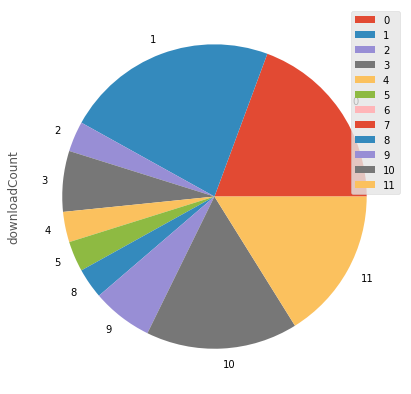

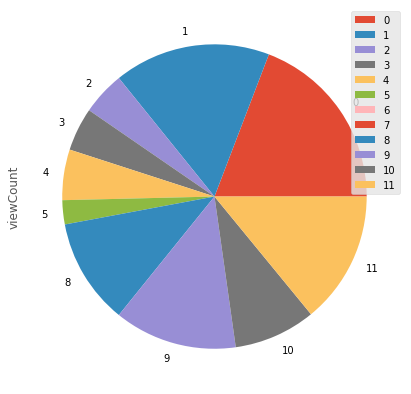

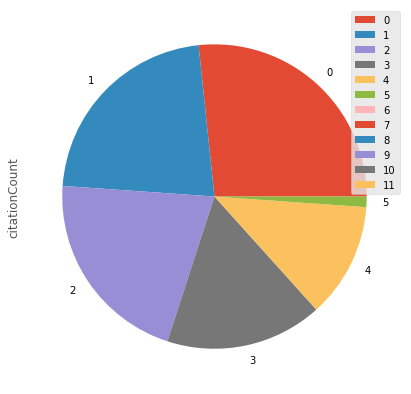

In [12]:
datasets_data.plot.pie(y='downloadCount', figsize=(7,7))
datasets_data.plot.pie(y='viewCount', figsize=(7,7))
datasets_data.plot.pie(y='citationCount', figsize=(7,7))

In [13]:
dd_sort_views=datasets_data.sort_values(by=['viewCount'], ascending=False)
ids = dd_sort_views['id'].value_counts()
maxi = dd_sort_views['viewCount'].max()
display(dd_sort_views,ids.sum(),maxi)

,id,downloadCount,viewCount,citationCount,Index,wtIndex
0,https://doi.org/10.14291/tccon.ggg2014.darwin0...,6,75,24,105,183
1,https://doi.org/10.14291/tccon.ggg2014.wollong...,7,65,20,92,159
11,https://doi.org/10.14291/tccon.ggg2014.orleans...,5,55,0,60,65
9,https://doi.org/10.14291/tccon.ggg2014.bremen0...,2,51,0,53,55
8,https://doi.org/10.14291/tccon.ggg2014.nyalesu...,1,44,0,45,46
10,https://doi.org/10.14291/tccon.ggg2014.bialyst...,5,34,0,39,44
4,https://doi.org/10.14291/tccon.ggg2014.bialyst...,1,21,11,33,67
2,https://doi.org/10.14291/tccon.ggg2014.orleans...,1,18,19,38,96
3,https://doi.org/10.14291/tccon.ggg2014.bremen0...,2,18,15,35,82
5,https://doi.org/10.14291/tccon.ggg2014.nyalesu...,1,10,1,12,16


12

75

In [ ]:

seriesObj = dd_sort_views.apply(lambda x: True if x['downloadCount'] > 0 else False , axis=1)
display(len(dd_sort_views['downloadCount'].index))
seriesObj.__class__
li=pd.Series([*range(len(dd_sort_views['downloadCount'].index),0,-1)])
dcdf=pd.DataFrame(dd_sort_views['downloadCount'].sort_values(ascending = False))
dcdf['li'] = [*range(len(dd_sort_views['downloadCount'].index),0,-1)]
dcdf['lis']=dcdf.apply(lambda x: x.li == x.downloadCount, axis=1)



display(dcdf)

In [130]:
import numpy as np
import math
descending_df = pd.DataFrame(datasets_data['downloadCount'])
descending_df.columns = ['count']
descending_df=descending_df.sort_values(by=['count'], ascending=False)
series = descending_df.apply(lambda x: True if x['count'] > 0 else False , axis=1)
cited_papers = len(series[series == True].index)

ranger = [cited_papers,0,-1]
g_max = math.floor(np.sqrt(descending_df['count'].sum()))

if g_max <= cited_papers:
    g = g_max
else:
    g = 0
    k = True
    while k:
        g += 1 
        if g >= g_max:
            k = False
    
print(g)
    




5


In [ ]:
def f(x):
    return x*2
    

In [ ]:
seriesObj = dd_sort_views['citationCount'].apply(lambda x: True if x > 0 else False)

In [ ]:
[h_index(dd_sort_views['downloadCount']),h_index(dd_sort_views['viewCount']),h_index(dd_sort_views['citationCount'])]

In [ ]:
(dd_sort_views['downloadCount'].sum())/(dd_sort_views['downloadCount'].shape[0])